# EECS 731 Project 5: Time Series Forecasting

## by Matthew Taylor

### Import required modules

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
%matplotlib inline
register_matplotlib_converters()

### Import product demand dataset
This dataset contains the demand of many products over a range of many years. There is a large amount of extraneous information in this dataset which must be removed before any training can be performed.

In [2]:
df = pd.read_csv('data/product_demand.csv')
df = df.dropna()
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


### Find products with the most available information
Ideally, I'd like to focus on a product with a large amount of available information. Thankfully, there are thousands of observations for multiple products.

In [3]:
df['Product_Code'].value_counts()[:3]

Product_1359    16936
Product_1295    10575
Product_1378     9770
Name: Product_Code, dtype: int64

### Remove unnecessary data
For this project, I decided to focus on product 1378. Once I had this decided, removed every row containing information on other products, as well as some other irrelevant columns.

In [4]:
df = df.loc[df['Product_Code'] == 'Product_1378']
df = df.drop(columns=['Product_Code', 'Warehouse', 'Product_Category'])
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Date'])
df = df.reset_index(drop=True)
df.head()

,Date,Order_Demand
0,2012-01-05,2000
1,2012-01-05,21000
2,2012-01-05,10000
3,2012-01-05,1000
4,2012-01-05,100


### Group demand values by day
For some reason, this dataset contains multiple rows for a single product on a single day. It would make far more sense to group order demand by day. Once this is done, we have a standard time series.

In [5]:
demands = []

for index, row in df.iterrows():
    demands.append(int(row['Order_Demand'].strip('()')))
    
df['Demand'] = demands
df = df.groupby('Date').agg({'Demand': 'sum'})

df.head()

,Demand
Date,
2012-01-05,149300
2012-01-06,152200
2012-01-10,48400
2012-01-11,33900
2012-01-12,26600


### Split data into training and testing subsets
It's important to note that when splitting a time series in to training and testing sets that shuffling is undesireable. The ideal split is temporal, where the training set contains every observation before some time and the testing set contains every observation after some time. In this project, I decide to use an 80/20 split.

In [6]:
# Removing the shuffle feature is required when
# performing the train-test split on time-series data

x = df.index.values
y = df.Demand.values
train_input, test_input, train_output, test_output = train_test_split(x, y, test_size=.2, shuffle=False)

### Decomposition
Here I use time series decomposition to check for any underlying trends, like seasonality. There appears to be an obvious upward trend as time goes on, as seen in the second plot. Furthermore, there appears to be some repetition in the seasonality of this time series.

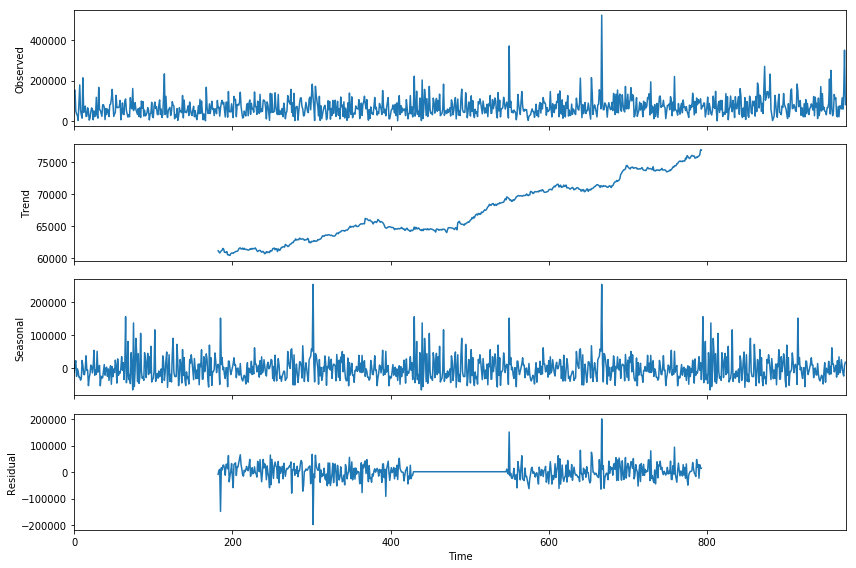

In [7]:
# This ensures a trend exists below the noise
# We can exploit this underlying trend to make predictions

decomp = seasonal_decompose(train_output, freq=365)
plt.rcParams['figure.figsize'] = [12, 8]
decomp.plot()
plt.show()

### Linear Regression
A simple approach to time series forecasting is linear regression. While this technique isn't able to capture any trends, it predicts the general trend quite well in this case.

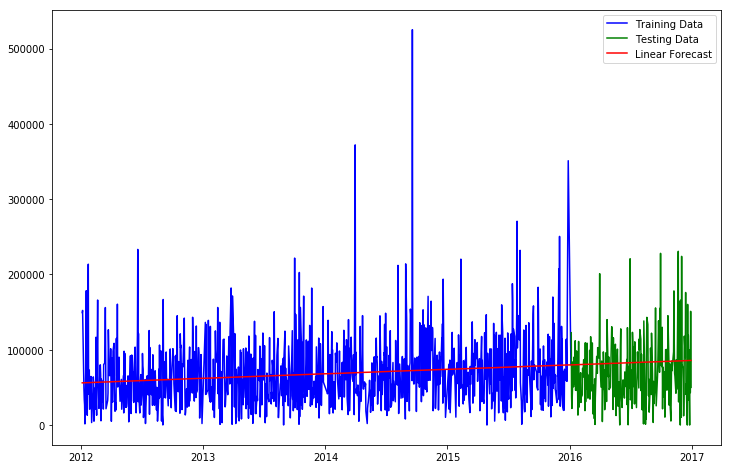

In [8]:
# The trend had a somewhat linear shape.
# Here, we begin forecasting with a simple linear regression model

linear_model = LinearRegression().fit(np.array(range(976)).reshape(-1, 1), train_output)
linear_forecast = [linear_model.predict(np.array(x).reshape(-1, 1)) for x in range(1221)]
plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(train_input, train_output, color='blue', label='Training Data')
plt.plot(test_input, test_output, color='green', label='Testing Data')
plt.plot(x, linear_forecast, color='red', label='Linear Forecast')
plt.legend(loc='best')
plt.show()

In [9]:
# Calculate MSE for quantitative accuracy

y_true = test_output
y_predicted = [linear_model.predict(np.array(x).reshape(-1, 1)) for x in range(976, 1221)]
mean_squared_error(y_true, y_predicted)

2049221455.0350895

### ARIMA forecasting
The ARIMA model is far more elaborate than the linear regression model. As such, it's able to forecast the time series slightly more accurately. 

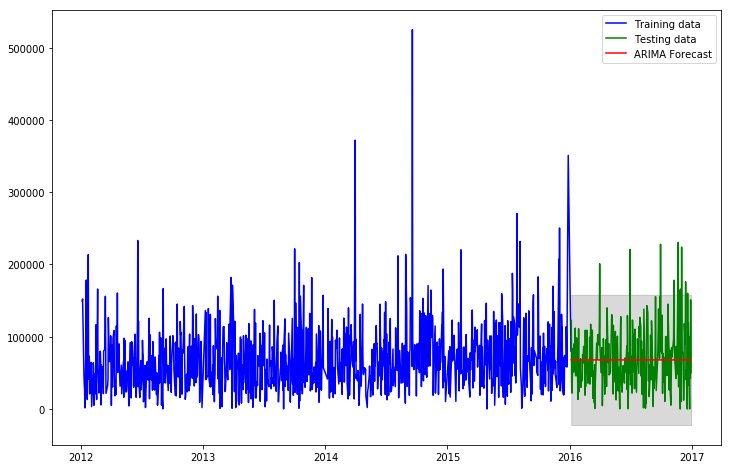

In [10]:
# A more advanced model may yield better results

# Using trial and error, I found a pqr order of (1, 0, 0) yields the lowest mse
model = ARIMA(train_output, order=(1, 0, 0))
model_fit = model.fit()

forecast, se, conf = model_fit.forecast(245, alpha=0.05)

lower_bound = conf[:, 0]
upper_bound = conf[:, 1]

plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(train_input, train_output, color='blue', label='Training data')
plt.plot(test_input, test_output, color='green', label='Testing data')
plt.plot(test_input, forecast, color='red', label='ARIMA Forecast')
plt.fill_between(test_input, lower_bound, upper_bound, color='black', alpha=0.15)
plt.legend(loc='best')

plt.show()

In [11]:
# The ARIMA model is slightly more accurate than the linear regression model

mean_squared_error(y_true, forecast)

1928562728.5930307